In [1]:
from sympy import symbols, I, exp, solve, conjugate, simplify, powsimp, Function, dsolve, Mul
from sympy.physics.quantum import Dagger
from sympy.physics.quantum.boson import BosonOp
from sympy import init_printing
from sympy.physics.quantum.operator import Operator
from sympy.physics.quantum.operatorordering import normal_ordered_form
from symbosonkit import similarity_transform, collect_terms, drop_terms_containing, drop_c_number_terms, hamiltonian_transformation, OperatorFunction, coeff_of, _normal

init_printing()

True


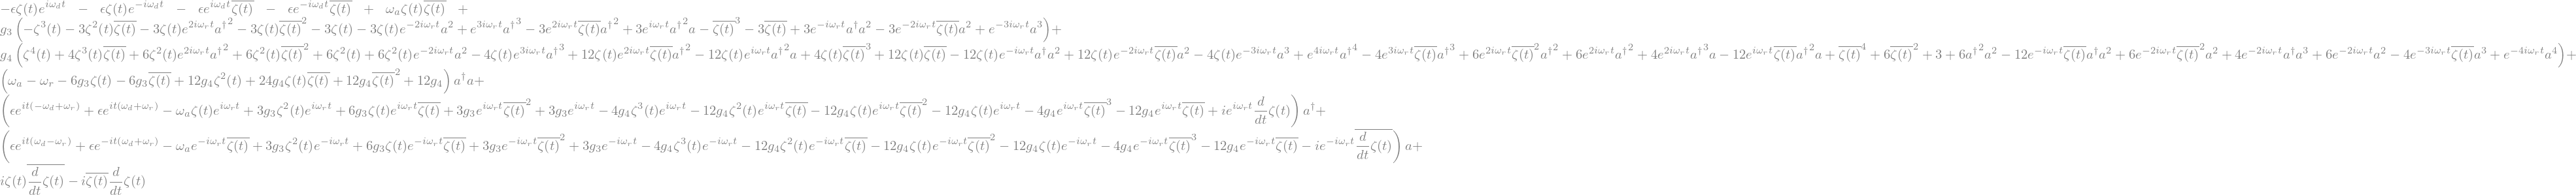

In [2]:
a = BosonOp('a')
adag = Dagger(a)

wa, g3, g4, wr, wd, t = symbols('\\omega_a g3 g4 \\omega_r \\omega_d t', real=True)
eps = symbols('\\epsilon', complex=True)
zeta = Function('\\zeta', complex=True)
zeta_t = zeta(t)

H = wa * adag * a + g3 * (adag + a)**3 + g4 * (adag + a)**4 + eps * (a + adag) * (exp(I * wd * t) + exp(-I * wd * t))

# zeta = zeta * exp(I * wr * t)

R = exp(I * wr * adag * a * t)
D = exp(zeta_t * adag - conjugate(zeta_t) * a)

H_transformed = hamiltonian_transformation(H, D, expand=True)
H_transformed = hamiltonian_transformation(H_transformed, R, expand=True)
H_transformed = collect_terms(H_transformed.expand(), [adag*a, a, adag, g3, g4])

Htest = hamiltonian_transformation(H, D, expand=False)
Htest = hamiltonian_transformation(Htest, R, expand=False)
Htest = collect_terms(normal_ordered_form(Htest.expand()), [adag*a, a, adag, g3, g4])

print(Htest == H_transformed)

H_transformed = powsimp(H_transformed)
H_transformed

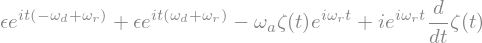

In [3]:
adag_coeff = drop_terms_containing(coeff_of(H_transformed, adag), [g3, g4])
adag_coeff

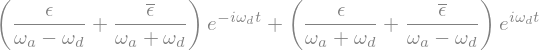

In [4]:
ss_zeta_t = dsolve(adag_coeff, zeta_t).rhs # steady state solution for zeta(t), keep specific solution
ss_zeta_t = drop_terms_containing(ss_zeta_t, [exp(I * wa * t), exp(-I * wa * t)]) # drop terms that contain time dependence
collect_terms(ss_zeta_t + Dagger(ss_zeta_t), [exp(I * wd * t), exp(-I * wd * t)]) # collect terms in steady state solution

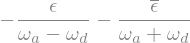

In [5]:
zeta_eff = -coeff_of(collect_terms(ss_zeta_t + Dagger(ss_zeta_t), [exp(I * wd * t), exp(-I * wd * t)]), exp(-I * wd * t))
zeta_eff

Set all $\zeta(t) + \overline{\zeta(t)} = \zeta_{eff}  e^{-i \omega_d t} + \overline{\zeta_{eff}}  e^{i \omega_d t}$

And drop the terms the above ODE cancels + all c-numbers:

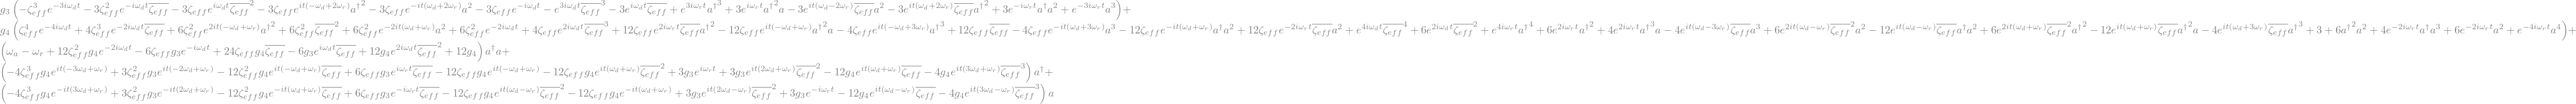

In [6]:
zeta_eff_sym = symbols('\\zeta_{eff}', complex=True)
D_eff = exp(zeta_eff_sym * exp(-I * wd * t) * adag - conjugate(zeta_eff_sym) * exp(I * wd * t) * a)

H_transformed = hamiltonian_transformation(H, D_eff, expand=False)
H_transformed = hamiltonian_transformation(H_transformed, R, expand=False)

# The zeta_eff sub cancels the linear terms in a, adag, so we can drop them. And RWA on the drive term
H_transformed = drop_terms_containing(H_transformed, [I, eps, wa]) + wa * adag * a
H_transformed = drop_c_number_terms(powsimp(collect_terms(normal_ordered_form(H_transformed.expand()), [adag*a, a, adag, g3, g4])))

H_transformed

#### Notice all terms coeff to $a$ and $a^\dag$ will rotate fast due to $\omega_d$. Drop them.

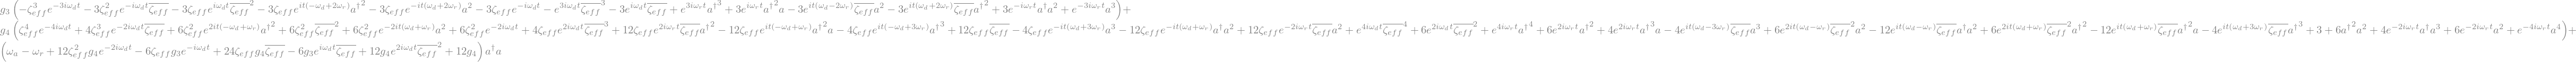

In [7]:
adag_a_coeff = coeff_of(H_transformed, adag*a) * adag * a
H_transformed = drop_terms_containing(H_transformed, [a, adag])
H_transformed += adag_a_coeff
H_transformed

#### Drop all terms that are just $c*\omega_d$, they're only slowly varying if $\omega_d=0$

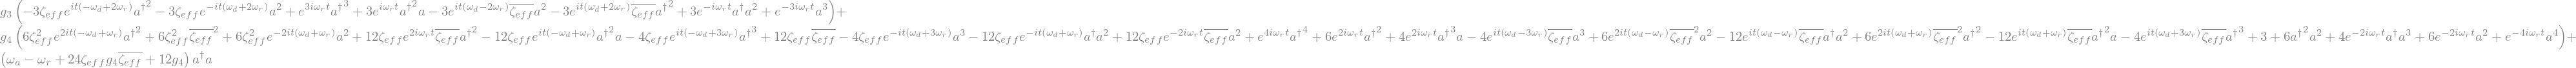

In [8]:
terms = []
for term in H_transformed.args:
    args = []
    for arg in term.args:
        arg = drop_terms_containing(arg, [exp(I * wd * t), exp(-I * wd * t), 
                                          exp(I * 2*wd * t), exp(-I * 2*wd * t),
                                          exp(I * 3*wd * t), exp(-I * 3*wd * t),
                                          exp(I * 4*wd * t), exp(-I * 4*wd * t)],
                                          deep=True)
        args.append(arg)
    terms.append(Mul(*args))

H_transformed = sum(terms)
H_transformed


### Case 1 - Kerr Hamiltonian
Let $\omega_r=\frac{\omega_d}{2}$ adn drop all fast rotating terms

In [9]:
H_kerr = H_transformed.subs({2*wr - wd: 0, wd - 2 * wr: 0})
H_kerr = drop_terms_containing(H_kerr, [exp(-I * t * (wd + 2*wr)), exp(I * t * (wd + 2*wr)),
                                        exp(I * wr * t), exp(-I * wr * t),
                                        exp(I * 2*wr * t), exp(-I * 2*wr * t),
                                        exp(I * 3*wr * t), exp(-I * 3*wr * t),
                                        exp(I * 4*wr * t), exp(-I * 4*wr * t),
                                        exp(I * t * (wd + wr)), exp(-I * t * (wd + wr)),
                                        exp(I * t * (wd - wr)), exp(-I * t * (wd - wr)),
                                        exp(I * t * 2 * (wd + wr)), exp(-I * t * 2 * (wd + wr)),
                                        exp(I * t * 2 * (wd - wr)), exp(-I * t * 2 * (wd - wr)),
                                        exp(I * t * (wd + 3*wr)), exp(-I * t * (wd + 3*wr)),
                                        exp(I * t * (wd - 3*wr)), exp(-I * t * (wd - 3*wr))],
                                        deep=True)
H_kerr = collect_terms(drop_c_number_terms(normal_ordered_form(H_kerr.expand())), [adag*a, adag**2 * a**2, adag**2, a**2])
H_kerr

#### Let Kerr be $K=-6 g_4$, $\Delta_a = \omega_a - \omega_r$, $\epsilon_2 = -3 \zeta_{eff} g_3$

$H_{kerr} = (\Delta_a -2K(1 + 2 |\zeta_{eff}|^2)) a^\dag a - K {a^\dag}^2 a^2 + \epsilon_2 {a^\dag}^2 + \overline{\epsilon_2} a^2$

### Case 3 - 3 Photon dissipation

Let $\omega_r = \frac{\omega_d}{3}$

In [10]:
H_3ph = H_transformed.subs({3*wr - wd: 0, wd - 3 * wr: 0})
H_3ph = drop_terms_containing(H_3ph, [exp(-I * t * (wd + 2*wr)), exp(I * t * (wd + 2*wr)),
                                        exp(I * wr * t), exp(-I * wr * t),
                                        exp(I * 2*wr * t), exp(-I * 2*wr * t),
                                        exp(I * 3*wr * t), exp(-I * 3*wr * t),
                                        exp(I * 4*wr * t), exp(-I * 4*wr * t),
                                        exp(I * t * (wd + wr)), exp(-I * t * (wd + wr)),
                                        exp(I * t * (wd - wr)), exp(-I * t * (wd - wr)),
                                        exp(I * t * 2 * (wd + wr)), exp(-I * t * 2 * (wd + wr)),
                                        exp(I * t * 2 * (wd - wr)), exp(-I * t * 2 * (wd - wr)),
                                        exp(I * t * (wd + 3*wr)), exp(-I * t * (wd + 3*wr)),
                                        exp(I * t * (wd - 2*wr)), exp(-I * t * (wd - 2*wr))],
                                        deep=True)
H_3ph = collect_terms(drop_c_number_terms(normal_ordered_form(H_3ph.expand())), [adag*a, adag**2 * a**2, adag**2, a**2])
H_3ph

Let $\epsilon_3 = -4 \zeta_{eff} g_4 = \frac{2}{3} K \zeta_{eff}$

$H_{3ph} = (\Delta_a -2K(1 + 2 |\zeta_{eff}|^2)) a^\dag a - K {a^\dag}^2 a^2 + \epsilon_3 {a^\dag}^3 + \overline{\epsilon_3} a^3$